

## Pneumonia Detection


Medical applications are amongst the fastest growing areas of application of deep learning today. Clinical screening offers a particularly exciting field of use as automated, or semi-automated, systems could massively increase the numbers of people who can be screened. Here we will build machine learning models to detect pneumonia from chest x-ray images.

We will build convolutional neural network based detectors of pneumonia from chest x-ray images. The chest x-ray set contains a training set of 5,235 images and a test set of 627 images. Dataset can be found in the links below


__Full dataset:__ https://www.dropbox.com/s/i8engt222brp5ys/chest_xray.zip?dl=0

__Small data sample:__ https://www.dropbox.com/s/nsvrw36327ej6db/chest_xray_small.zip?dl=0 

## Importing required packages

In [1]:
# Importing necessary libraries.

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### 1: Load the Chest x-ray dataset and become familiar with its contents.

I have downloaded the full datset and kept on my local machine and then performed all operations

In [2]:
# Assigning the chest_xray images dataset in dataset_name
dataset_name = r'./chest_xray/chest_xray/'

# assuming data is contained in a train dataset directory.
train_data_dir = dataset_name + '/train/'
test_data_dir = dataset_name + '/test/'

# Set up some parameters for data loading
sample_rate = 0.2

### SETTING RESIZED SHAPE: (162 * 128)

In [3]:
# desired dimensions of our images.
img_width, img_height = 162, 128

# different backends (e.g. tensorflow and theano) use different orderings for image data - fix this!
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### PROCESSING THE TRAINING DATASET

In [4]:
# List of all categories within training dataset. 
training_class_folders = [i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset

# the number of categories.
num_classes = len(training_class_folders)

# Initialise arrays for data storage.
X_data = np.ndarray((0, input_shape[0], input_shape[1]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)
    
# Loop through the categories folders.
for i, image_cls in enumerate(training_class_folders):
    
    print('\n\nProcessing class {}'.format(image_cls))
    
    # image_class_folder depicts the NORMAL or PNEUMONIA category.
    image_class_folder = train_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling.
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for each class image data.
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1]), dtype=np.float)

    # Iterate through the filenames and for each one load the image, resize and normalise.
    for i, image_file in enumerate(image_filenames):

        # Lower the images and resize them
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        #image = image[:,:,[2,1,0]] # OpenCV and matplotlib use different channel orderings so fix this.
        
        # If channel order of network does not match open cv format swap it.
        #if K.image_data_format() == 'channels_first':
        #    image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise.
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        # Add label to label array.
        y_data = np.append(y_data, image_cls)
            
        if i%50 == 0: 
            print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('\nProcessed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array.
    X_data = np.append(X_data, X_data_part, axis=0)
    
print("\nData shape: {}".format(X_data.shape))

# Assigning the X_train and y_train with X_data and y_data
X_train = X_data
y_train = y_data



Processing class NORMAL
Processed 0 of 269 for class NORMAL 
Processed 50 of 269 for class NORMAL 
Processed 100 of 269 for class NORMAL 
Processed 150 of 269 for class NORMAL 
Processed 200 of 269 for class NORMAL 
Processed 250 of 269 for class NORMAL 

Processed 269 of 269 for class NORMAL 


Processing class PNEUMONIA
Processed 0 of 776 for class PNEUMONIA 
Processed 50 of 776 for class PNEUMONIA 
Processed 100 of 776 for class PNEUMONIA 
Processed 150 of 776 for class PNEUMONIA 
Processed 200 of 776 for class PNEUMONIA 
Processed 250 of 776 for class PNEUMONIA 
Processed 300 of 776 for class PNEUMONIA 
Processed 350 of 776 for class PNEUMONIA 
Processed 400 of 776 for class PNEUMONIA 
Processed 450 of 776 for class PNEUMONIA 
Processed 500 of 776 for class PNEUMONIA 
Processed 550 of 776 for class PNEUMONIA 
Processed 600 of 776 for class PNEUMONIA 
Processed 650 of 776 for class PNEUMONIA 
Processed 700 of 776 for class PNEUMONIA 
Processed 750 of 776 for class PNEUMONIA 

Proc

### PROCESSING THE TEST DATASET

In [5]:
# List of all categories within testing dataset. 
testing_class_folders = [i for i in os.listdir(test_data_dir) if not i.startswith('.')] # use this for full dataset

# the number of categories.
num_classes = len(testing_class_folders)

# Initialise arrays for data storage.
X_test_data = np.ndarray((0, input_shape[0], input_shape[1]), dtype=np.float)
y_test_data= np.ndarray(0, dtype=np.str)
    
# Loop through the categories folders.
for i, image_cls in enumerate(testing_class_folders):
    
    print('\n\nProcessing class {}'.format(image_cls))
    
    # image_class_folder depicts the NORMAL or PNEUMONIA category.
    image_class_folder = test_data_dir + image_cls + "/"
    
    # generate filenames from the data folder and do sampling.
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for each class image data.
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1]), dtype=np.float)

    # Iterate through the filenames and for each one load the image, resize and normalise.
    for i, image_file in enumerate(image_filenames):

        # Lower the images and resize them
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        #image = image[:,:,[2,1,0]] # OpenCV and matplotlib use different channel orderings so fix this.
            
        # Add image data to data array and normalise.
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        # Add label to label array.
        y_test_data = np.append(y_test_data, image_cls)
            
        if i%20 == 0: 
            print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('\nProcessed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array.
    X_test_data = np.append(X_test_data, X_data_part, axis=0)
    
print("\nData shape: {}".format(X_test_data.shape))

# Assigning the X_test and y_test with X_data and y_data
X_test = X_test_data
y_test = y_test_data



Processing class NORMAL
Processed 0 of 46 for class NORMAL 
Processed 20 of 46 for class NORMAL 
Processed 40 of 46 for class NORMAL 

Processed 46 of 46 for class NORMAL 


Processing class PNEUMONIA
Processed 0 of 78 for class PNEUMONIA 
Processed 20 of 78 for class PNEUMONIA 
Processed 40 of 78 for class PNEUMONIA 
Processed 60 of 78 for class PNEUMONIA 

Processed 78 of 78 for class PNEUMONIA 

Data shape: (124, 162, 128)


In [6]:
# displaying few chest xray images from the training dataset.
pltsize=4

# 25 images (5 * 5) are displayed.
row_images = 3
col_images = 3

plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    # excluding the axis.
    plt.axis('off')
    # displays the image.
    plt.imshow(X_train[i_rand])
    # Title consists of random number along with the y_train class labels.
    plt.title((str(i_rand) + " " + y_train[i_rand]))
    # print('Training sample',i_rand,': class:',y_train[i_rand])

===================================================================================================================

### 2: As a simple baseline train a logistic regression model to perform the classification task.

#### Reshaping the Training and Test Dataset from Multi- Dimensional to 1 Dimension for  Logistic Regression Classifier.

In [7]:
# Logistic Regression classifier requires the input to be of format (Observation, Label). Thus flattening the training and test dataset.
X_train_reshaped = X_train.flatten().reshape(X_train.shape[0],(X_train[0].shape[0] * X_train[1].shape[1]))
X_test_reshaped = X_test.flatten().reshape(X_test.shape[0],(X_test[0].shape[0] * X_test[1].shape[1]))

#### Encoding Categorical classes to Numerical

In [8]:
# In order to encode the categorical target values from the training and test dataset to numerical values. (NORMAL -> 0 and PNEUMONIA -> 1)
y_train_encoder = sklearn.preprocessing.LabelEncoder()

y_train_num = y_train_encoder.fit_transform(y_train)
y_test_num = y_train_encoder.fit_transform(y_test)

In [9]:
# A dictionary to store the target values of chest xray images with their numerical encoding as key.
classes_num_label = dict()

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl
    
classes_num_label

{0: 'NORMAL', 1: 'PNEUMONIA'}

### LOGISTIC REGRESSION MODEL

In [10]:
print('...Logistic Regression Model...')

# Hyperparameter space
params = {
    'C': [0.1,0.5]
}

# Instantiate the model class
# The parameter class_weight is set to 'balanced' so as to balance the dataset.
model = LogisticRegression(class_weight='balanced', random_state=42)

# Search for the best hyperparameters combination
print('...Searching for the best hyperparameter...')
model = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train_reshaped, y_train_num)

best_hyperparameters = model.best_params_
best_score = model.best_score_
print('Best hyperparameters: {}'.format(best_hyperparameters))
print('Best score: {}'.format(best_score))

...Logistic Regression Model...
...Searching for the best hyperparameter...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   30.9s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   39.7s finished


Best hyperparameters: {'C': 0.5}
Best score: 0.9671771576867274


### EVALUATION ON TRAIN DATASET

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       1.00      1.00      1.00       776

    accuracy                           1.00      1045
   macro avg       1.00      1.00      1.00      1045
weighted avg       1.00      1.00      1.00      1045

Confusion matrix


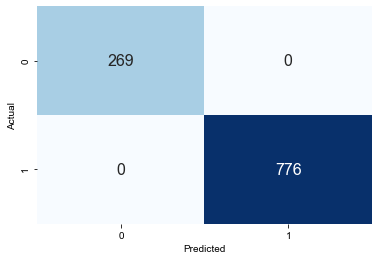

In [11]:
# Make a set of predictions for the training data

pred = model.predict(X_train_reshaped)

# Performance evaluation of Logistic Regression on training dataset.
train_acc_LogReg = accuracy_score(y_train_num,pred)
#print(train_acc_LogReg)

# Print performance details
print(metrics.classification_report(y_train_num, pred))

print("Confusion matrix")
cm = metrics.confusion_matrix(y_train_num, pred)
      
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### EVALUATION ON TEST DATASET

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        46
           1       0.77      1.00      0.87        78

    accuracy                           0.81       124
   macro avg       0.89      0.75      0.77       124
weighted avg       0.86      0.81      0.80       124

Confusion matrix


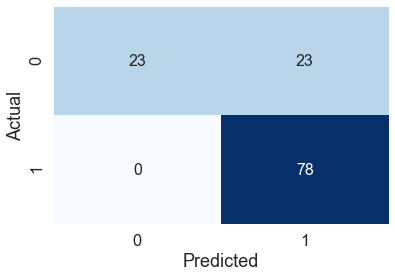

In [12]:
# Make a set of predictions for the testing data

pred = model.predict(X_test_reshaped)

# Performance evaluation of Logistic Regression on testing dataset.
test_acc_LogReg = accuracy_score(y_test_num,pred)
#print(test_acc_LogReg)

# Print performance details
print(metrics.classification_report(y_test_num, pred))

print("Confusion matrix")
cm = metrics.confusion_matrix(y_test_num, pred)

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
# Bar graph depicting the accuracy of Logistic Regression performing on Training and Test dataset .
plt.bar(['Train','Test'],[train_acc_LogReg,test_acc_LogReg], width = 0.6)
plt.title('Logistic Regression Accuracy on Training and Test Dataset.')
plt.xlabel('Dataset')
plt.ylabel('Accuracy Score')
plt.show()

=======================================================================================================================

### 3: Train a convolutional neural network model to recognise pneumonia in these images.

#### 3.1 : Trying the classic LeNet-5 model architecture.
#### 3.2 : Shrinking the images (perhaps to 162 x 128).
#### 3.3 : Performing a suitable evaluation experiment to determine how effective the model trained is.
#### 3.4 : Balancing the dataset

### PROCESSING COLORED IMAGES OF TRAINING DATASET

In [14]:
# Initialise arrays for data storage.
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)
    
# Loop through the categories folders.
for i, image_cls in enumerate(training_class_folders):
    
    print('\n\nProcessing class {}'.format(image_cls))
    
    # image_class_folder depicts the NORMAL or PNEUMONIA category.
    image_class_folder = train_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling.
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for each class image data.
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

    # Iterate through the filenames and for each one load the image, resize and normalise.
    for i, image_file in enumerate(image_filenames):

        # Lower the images and resize them
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use different channel orderings so fix this.
        
        # If channel order of network does not match open cv format swap it.
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise.
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        # Add label to label array.
        y_data = np.append(y_data, image_cls)
            
        if i%50 == 0: 
            print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('\nProcessed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array.
    X_data = np.append(X_data, X_data_part, axis=0)
    
print("\nData shape: {}".format(X_data.shape))

# Assigning the X_train and y_train with X_data and y_data
X_train = X_data
y_train = y_data



Processing class NORMAL
Processed 0 of 269 for class NORMAL 
Processed 50 of 269 for class NORMAL 
Processed 100 of 269 for class NORMAL 
Processed 150 of 269 for class NORMAL 
Processed 200 of 269 for class NORMAL 
Processed 250 of 269 for class NORMAL 

Processed 269 of 269 for class NORMAL 


Processing class PNEUMONIA
Processed 0 of 776 for class PNEUMONIA 
Processed 50 of 776 for class PNEUMONIA 
Processed 100 of 776 for class PNEUMONIA 
Processed 150 of 776 for class PNEUMONIA 
Processed 200 of 776 for class PNEUMONIA 
Processed 250 of 776 for class PNEUMONIA 
Processed 300 of 776 for class PNEUMONIA 
Processed 350 of 776 for class PNEUMONIA 
Processed 400 of 776 for class PNEUMONIA 
Processed 450 of 776 for class PNEUMONIA 
Processed 500 of 776 for class PNEUMONIA 
Processed 550 of 776 for class PNEUMONIA 
Processed 600 of 776 for class PNEUMONIA 
Processed 650 of 776 for class PNEUMONIA 
Processed 700 of 776 for class PNEUMONIA 
Processed 750 of 776 for class PNEUMONIA 

Proc

### PROCESSING TEST DATASET

In [15]:
# Initialise arrays for data storage.
X_test_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_test_data= np.ndarray(0, dtype=np.str)
    
# Loop through the categories folders.
for i, image_cls in enumerate(testing_class_folders):
    
    print('\n\nProcessing class {}'.format(image_cls))
    
    # image_class_folder depicts the NORMAL or PNEUMONIA category.
    image_class_folder = test_data_dir + image_cls + "/"
    
    # generate filenames from the data folder and do sampling.
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for each class image data.
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

    # Iterate through the filenames and for each one load the image, resize and normalise.
    for i, image_file in enumerate(image_filenames):

        # Lower the images and resize them
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image = image[:,:,[2,1,0]] # OpenCV and matplotlib use different channel orderings so fix this.
        
        # If channel order of network does not match open cv format swap it.
        if K.image_data_format() == 'channels_first':
            image=np.swapaxes(np.swapaxes(image, 1, 2), 0, 1)
            
        # Add image data to data array and normalise.
        X_data_part[i] = image
        X_data_part[i] = X_data_part[i]/255
        
        # Add label to label array.
        y_test_data = np.append(y_test_data, image_cls)
            
        if i%20 == 0: 
            print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('\nProcessed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array.
    X_test_data = np.append(X_test_data, X_data_part, axis=0)
    
print("\nData shape: {}".format(X_test_data.shape))

# Assigning the X_test and y_test with X_data and y_data
X_test = X_test_data
y_test = y_test_data



Processing class NORMAL
Processed 0 of 46 for class NORMAL 
Processed 20 of 46 for class NORMAL 
Processed 40 of 46 for class NORMAL 

Processed 46 of 46 for class NORMAL 


Processing class PNEUMONIA
Processed 0 of 78 for class PNEUMONIA 
Processed 20 of 78 for class PNEUMONIA 
Processed 40 of 78 for class PNEUMONIA 
Processed 60 of 78 for class PNEUMONIA 

Processed 78 of 78 for class PNEUMONIA 

Data shape: (124, 162, 128, 3)


In [16]:
# Convert class vectors to binary class matrices.
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

### 3.1 : LeNet-5 Model

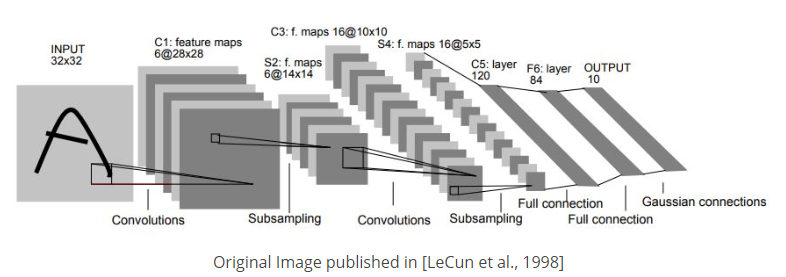

In [17]:
model = Sequential()
#Convolution1
model.add(Conv2D(32, (5, 5), input_shape=input_shape))
model.add(Activation('relu'))

#Pooling2
model.add(AveragePooling2D(pool_size=(2, 2)))

#Convolution3
model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))

#Pooling4
model.add(AveragePooling2D(pool_size=(2, 2)))

#Convolution5
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Using adam optimizer with learning rate: 0.0001
opt = adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 158, 124, 32)      2432      
_________________________________________________________________
activation_1 (Activation)    (None, 158, 124, 32)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 79, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 58, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 75, 58, 32)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 37, 29, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 25, 64)       

### TRAINING CNN (LeNet-5 MODEL)

In [18]:
batch_size = 128
epochs = 15

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './LeNet5.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

# Making the model to map the input with its labelled output.
history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

Train on 836 samples, validate on 209 samples
Epoch 1/15
836/836 [==============================] - 27s 32ms/step - loss: 0.6681 - accuracy: 0.6495 - val_loss: 0.5110 - val_accuracy: 1.0000
Epoch 2/15
836/836 [==============================] - 26s 31ms/step - loss: 0.5796 - accuracy: 0.6782 - val_loss: 0.2809 - val_accuracy: 1.0000
Epoch 3/15
836/836 [==============================] - 26s 31ms/step - loss: 0.4809 - accuracy: 0.7596 - val_loss: 0.1973 - val_accuracy: 1.0000
Epoch 4/15
836/836 [==============================] - 26s 32ms/step - loss: 0.3790 - accuracy: 0.8457 - val_loss: 0.1827 - val_accuracy: 0.9713
Epoch 5/15
836/836 [==============================] - 26s 31ms/step - loss: 0.2958 - accuracy: 0.8864 - val_loss: 0.1212 - val_accuracy: 0.9761
Epoch 6/15
836/836 [==============================] - 26s 32ms/step - loss: 0.2513 - accuracy: 0.8864 - val_loss: 0.1171 - val_accuracy: 0.9569
Epoch 7/15
836/836 [==============================] - 26s 31ms/step - loss: 0.2343 - accur

### 3.2: SHRINK THE IMAGES (162, 128) 

Images are resized to the desired size (162, 128) while processing training and testing data after loading the Chest X-ray dataset.

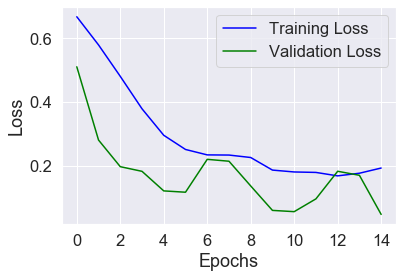

In [19]:
#Plotting the evaluation statistics
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### 3.3: EVALUATION EXPERIMENTS

### EVALUATION OF CNN ON TRAIN DATASET

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       269
           1       0.95      0.99      0.97       776

    accuracy                           0.95      1045
   macro avg       0.96      0.91      0.93      1045
weighted avg       0.95      0.95      0.95      1045

Confusion matrix


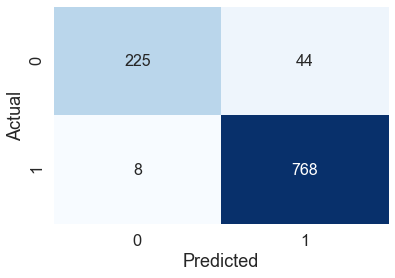

In [20]:
# Make a set of predictions for the training data
pred = model.predict_classes(X_train)
train_acc_CNN = accuracy_score(y_train_num,pred)

# Print performance details
print(metrics.classification_report(y_train_num, pred))


print("Confusion matrix")
cm = metrics.confusion_matrix(y_train_num, pred)

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### EVALUATION OF CNN ON TEST DATASET

              precision    recall  f1-score   support

           0       1.00      0.30      0.47        46
           1       0.71      1.00      0.83        78

    accuracy                           0.74       124
   macro avg       0.85      0.65      0.65       124
weighted avg       0.82      0.74      0.70       124

Confusion matrix


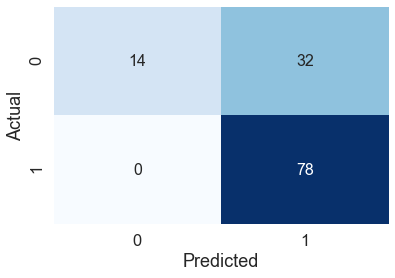

In [21]:
# Make a set of predictions for the training data
pred = model.predict_classes(X_test)
test_acc_CNN = accuracy_score(y_test_num,pred)

# Print performance details
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
cm =metrics.confusion_matrix(y_test_num, pred)

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

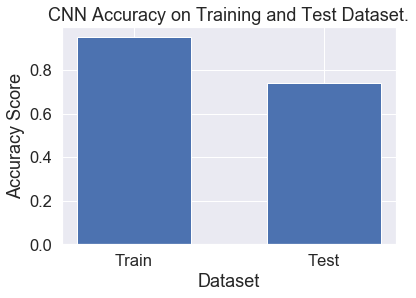

In [22]:
# Bar graph depicting the accuracy of CNN Model performing on Training and Test dataset .
plt.bar(['Train','Test'],[train_acc_CNN,test_acc_CNN], width = 0.6)
plt.title('CNN Accuracy on Training and Test Dataset.')
plt.xlabel('Dataset')
plt.ylabel('Accuracy Score')
plt.show()

### CNN CORRECT CLASSIFICATIONS

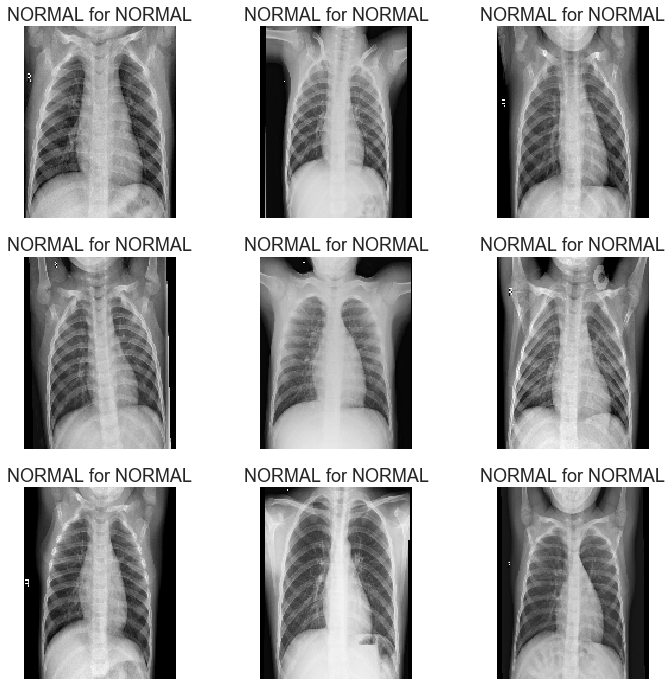

In [23]:
#Correct Classification
pltsize=4
row_images = 3
col_images = 3

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test[i])
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1

### CNN INCORRECT CLASSIFICATIONS

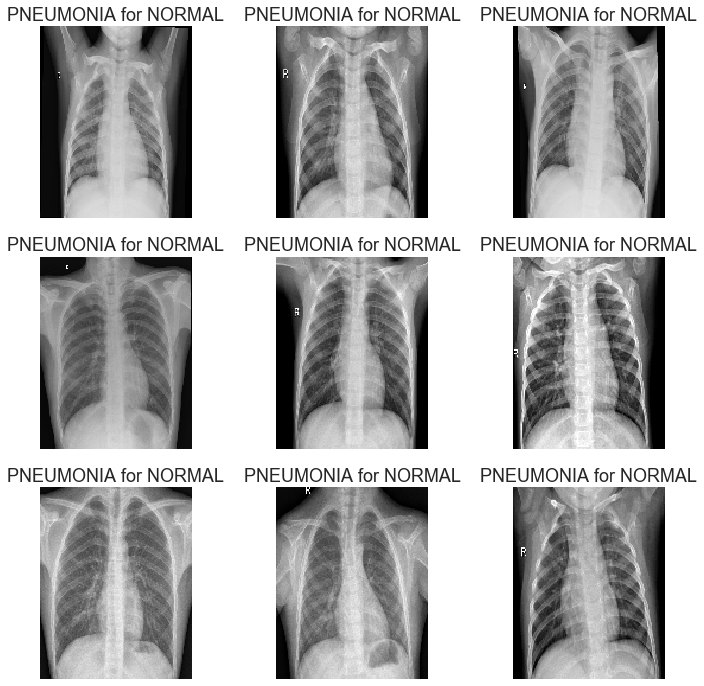

In [24]:
#Incorrect Classification
pltsize=4
row_images = 3
col_images = 3

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
errors = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test[i])
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1

### TASK 3.4: BALANCE THE DATASET.

### LeNet-5 MODEL 

In [25]:
model = Sequential()
#Convolution1
model.add(Conv2D(32, (5, 5), input_shape=input_shape))
model.add(Activation('relu'))

#Pooling2
model.add(AveragePooling2D(pool_size=(2, 2)))

#Convolution3
model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))

#Pooling4
model.add(AveragePooling2D(pool_size=(2, 2)))

#Convolution5
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = adam(lr = 0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 158, 124, 32)      2432      
_________________________________________________________________
activation_6 (Activation)    (None, 158, 124, 32)      0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 79, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 58, 32)        25632     
_________________________________________________________________
activation_7 (Activation)    (None, 75, 58, 32)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 37, 29, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 25, 64)       

In [26]:
batch_size = 128
epochs = 15

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './LeNet5.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)

history = model.fit(X_train, y_train_wide, class_weight='balanced',
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

Train on 836 samples, validate on 209 samples
Epoch 1/15
836/836 [==============================] - 27s 32ms/step - loss: 0.6904 - accuracy: 0.6459 - val_loss: 0.5156 - val_accuracy: 1.0000
Epoch 2/15
836/836 [==============================] - 26s 31ms/step - loss: 0.5509 - accuracy: 0.6986 - val_loss: 0.3397 - val_accuracy: 1.0000
Epoch 3/15
836/836 [==============================] - 26s 32ms/step - loss: 0.4283 - accuracy: 0.8325 - val_loss: 0.2650 - val_accuracy: 0.9426
Epoch 4/15
836/836 [==============================] - 26s 32ms/step - loss: 0.3339 - accuracy: 0.8648 - val_loss: 0.2093 - val_accuracy: 0.9330
Epoch 5/15
836/836 [==============================] - 28s 33ms/step - loss: 0.2792 - accuracy: 0.8864 - val_loss: 0.3037 - val_accuracy: 0.8660
Epoch 6/15
836/836 [==============================] - 35s 41ms/step - loss: 0.2501 - accuracy: 0.8911 - val_loss: 0.2144 - val_accuracy: 0.9187
Epoch 7/15
836/836 [==============================] - 28s 34ms/step - loss: 0.2263 - accur

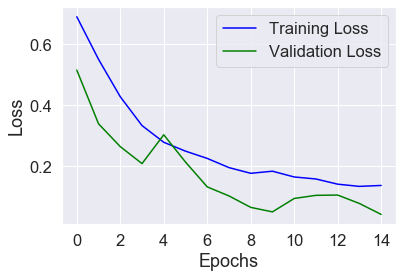

In [27]:
#Plotting the evaluation statistics
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### EVALUATION OF CNN ON BALANCED TRAINING DATASET

              precision    recall  f1-score   support

           0       0.98      0.23      0.38       269
           1       0.79      1.00      0.88       776

    accuracy                           0.80      1045
   macro avg       0.89      0.62      0.63      1045
weighted avg       0.84      0.80      0.75      1045

Confusion matrix


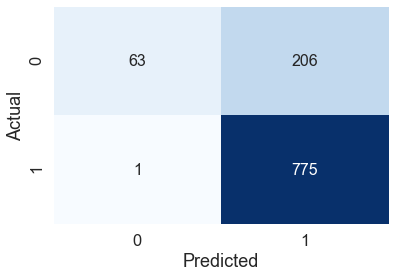

In [28]:
# Make a set of predictions for the training data
pred = model.predict_classes(X_train)
train_acc_Balanced = accuracy_score(y_train_num,pred)

# Print performance details
print(metrics.classification_report(y_train_num, pred))

print("Confusion matrix")
cm =metrics.confusion_matrix(y_train_num, pred)

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### EVALUATION OF CNN ON BALANCED TEST DATASET

              precision    recall  f1-score   support

           0       1.00      0.02      0.04        46
           1       0.63      1.00      0.78        78

    accuracy                           0.64       124
   macro avg       0.82      0.51      0.41       124
weighted avg       0.77      0.64      0.50       124

Confusion matrix


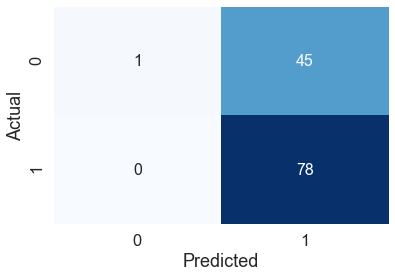

In [29]:
# Make a set of predictions for the training data
pred = model.predict_classes(X_test)
test_acc_Balanced = accuracy_score(y_test_num,pred)

# Print performance details
print(metrics.classification_report(y_test_num, pred))
print("Confusion matrix")
cm =metrics.confusion_matrix(y_test_num, pred)

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

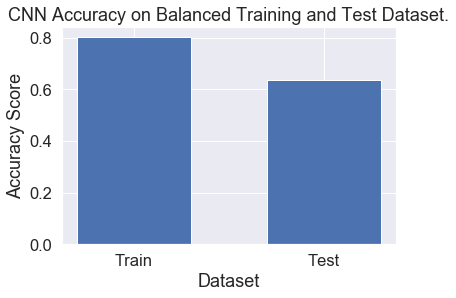

In [30]:
# Bar graph depicting the accuracy of CNN performing on balanced Training and Test dataset .
plt.bar(['Train','Test'],[train_acc_Balanced,test_acc_Balanced], width = 0.6)
plt.title('CNN Accuracy on Balanced Training and Test Dataset.')
plt.xlabel('Dataset')
plt.ylabel('Accuracy Score')
plt.show()

==================================================================================================================

### 4 : Use data augmentation techniques (for example image rotations or slight colour changes) to increase the size of the training dataset. Use the augmented dataset to train a model with the same model architecture that you used in Part 3.

Note: Think carefully about the types of transformations that are appropriate to use in this context (for example flipping images horizontally or vertically is not appropriate as x-ray images have a fixed frame of reference).

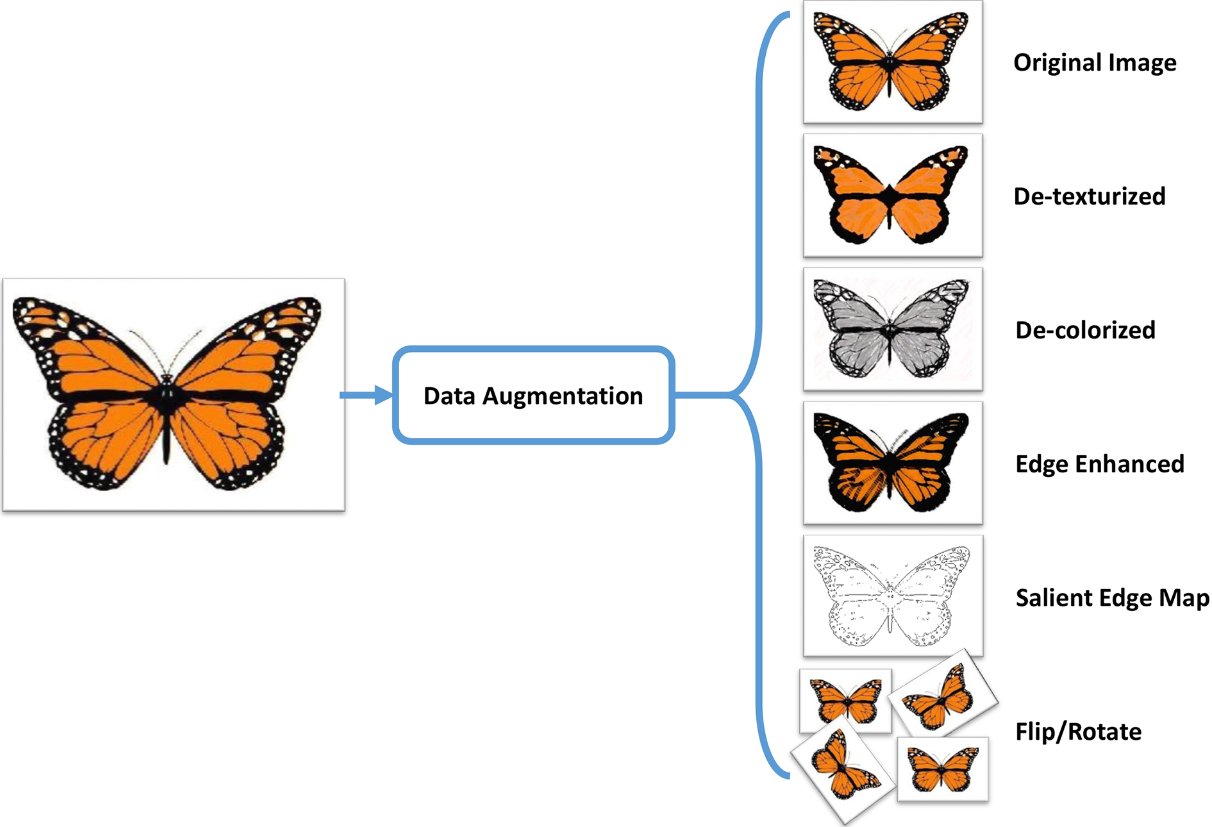

In [31]:
# Perfrom split to train, validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=0, test_size = 0.20, train_size = 0.8)

In [32]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

### DATA AUGMENTATION

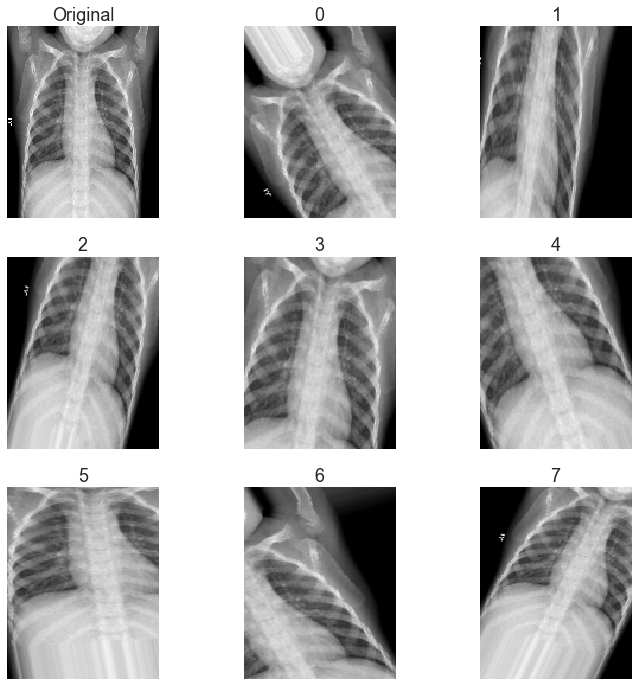

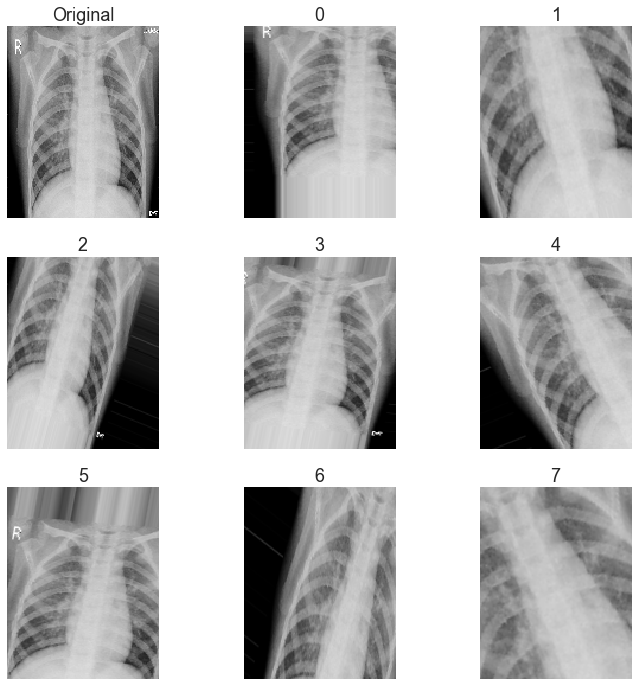

In [33]:
pltsize=4
row_images = 3
col_images = 3

# Create a transformed data generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    zoom_range=[0.5,1.2])

# fit parameters from data
datagen.fit(X_train)

for idx in range(0, 2):
    # Plot the original image
    plt.figure(figsize=(col_images*pltsize, row_images*pltsize))
    plt.subplot(row_images,col_images,1)
    plt.axis('off')
    plt.imshow(X_train[idx])
    plt.title("Original")

    for i in range(row_images * col_images - 1):
        rand_trans = datagen.random_transform(X_train[idx])
        plt.subplot(row_images,col_images,i+2)
        plt.axis('off')
        plt.imshow(rand_trans)
        plt.title(i)

    plt.show()             

### LeNet-5 Model Generation

In [34]:
model = Sequential()
#Convolution1
model.add(Conv2D(32, (5, 5), input_shape=input_shape))
model.add(Activation('relu'))

#Pooling2
model.add(AveragePooling2D(pool_size=(2, 2)))

#Convolution3
model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))

#Pooling4
model.add(AveragePooling2D(pool_size=(2, 2)))

#Convolution5
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = adam(lr = 0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 158, 124, 32)      2432      
_________________________________________________________________
activation_11 (Activation)   (None, 158, 124, 32)      0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 79, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 58, 32)        25632     
_________________________________________________________________
activation_12 (Activation)   (None, 75, 58, 32)        0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 37, 29, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 33, 25, 64)       

### TRAINING THE CNN MODEL ON AUGMENTED TRAIN DATA

In [35]:
batch_size = 128
epochs = 15

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './data_augmentation.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trianing data
datagen_train = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    zoom_range=[0.80,1.2],
    fill_mode= 'reflect')

datagen_train.fit(X_train)
        
history = model.fit_generator(datagen_train.flow(X_train, y_train_wide, batch_size=batch_size),
          steps_per_epoch=len(X_train) / batch_size,
          validation_data=(X_valid, y_valid_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath)

Epoch 1/15
7/6 [================================] - 29s 4s/step - loss: 0.6603 - accuracy: 0.7129 - val_loss: 0.4825 - val_accuracy: 0.8134
Epoch 2/15
7/6 [================================] - 33s 5s/step - loss: 0.5955 - accuracy: 0.7249 - val_loss: 0.5340 - val_accuracy: 0.8134
Epoch 3/15
7/6 [================================] - 35s 5s/step - loss: 0.5902 - accuracy: 0.7249 - val_loss: 0.4752 - val_accuracy: 0.8134
Epoch 4/15
7/6 [================================] - 31s 4s/step - loss: 0.5715 - accuracy: 0.7249 - val_loss: 0.5146 - val_accuracy: 0.8134
Epoch 5/15
7/6 [================================] - 27s 4s/step - loss: 0.5767 - accuracy: 0.7249 - val_loss: 0.4593 - val_accuracy: 0.8134
Epoch 6/15
7/6 [================================] - 28s 4s/step - loss: 0.5697 - accuracy: 0.7225 - val_loss: 0.4666 - val_accuracy: 0.8134
Epoch 7/15
7/6 [================================] - 28s 4s/step - loss: 0.5477 - accuracy: 0.7368 - val_loss: 0.4721 - val_accuracy: 0.8325
Epoch 8/15
7/6 [====

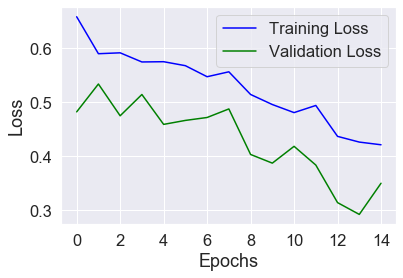

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### EVALUATION OF AUGMENTED CNN ON TRAIN DATASET

              precision    recall  f1-score   support

           0       0.91      0.53      0.67       230
           1       0.84      0.98      0.91       606

    accuracy                           0.86       836
   macro avg       0.88      0.75      0.79       836
weighted avg       0.86      0.86      0.84       836

Confusion matrix


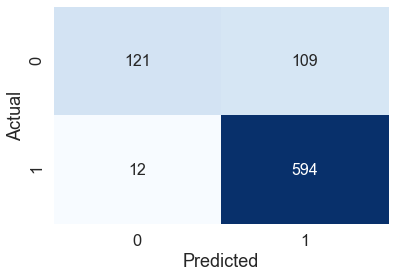

In [37]:
#Training accuracy
# Make a set of predictions for the validation data
pred = model.predict_classes(X_train)

train_acc_Aug = accuracy_score(y_train_num,pred)

# Print performance details
print(metrics.classification_report(y_train_num, pred))
print("Confusion matrix")
cm =metrics.confusion_matrix(y_train_num, pred)

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### EVALUATION OF AUGMENTED CNN ON TEST DATASET

In [38]:
#Testing accuracy
# Make a set of predictions for the validation data
pred = model.predict_classes(X_test)

test_acc_Aug = accuracy_score(y_test_num,pred)

# Print performance details
print(metrics.classification_report(y_test_num, pred))

print("Confusion matrix")
cm =metrics.confusion_matrix(y_test_num, pred)

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

              precision    recall  f1-score   support

           0       0.87      0.43      0.58        46
           1       0.74      0.96      0.84        78

    accuracy                           0.77       124
   macro avg       0.81      0.70      0.71       124
weighted avg       0.79      0.77      0.74       124

Confusion matrix


In [39]:
# Bar graph depicting the accuracy of Logistic Regression performing on Training and Test dataset .
plt.bar(['Train','Test'],[train_acc_Aug,test_acc_Aug], width = 0.6)
plt.title('Augmented CNN Accuracy on Training and Test Dataset.')
plt.xlabel('Dataset')
plt.ylabel('Accuracy Score')
plt.show()

### AUGMENTED CNN CORRECT CLASSIFICATIONS

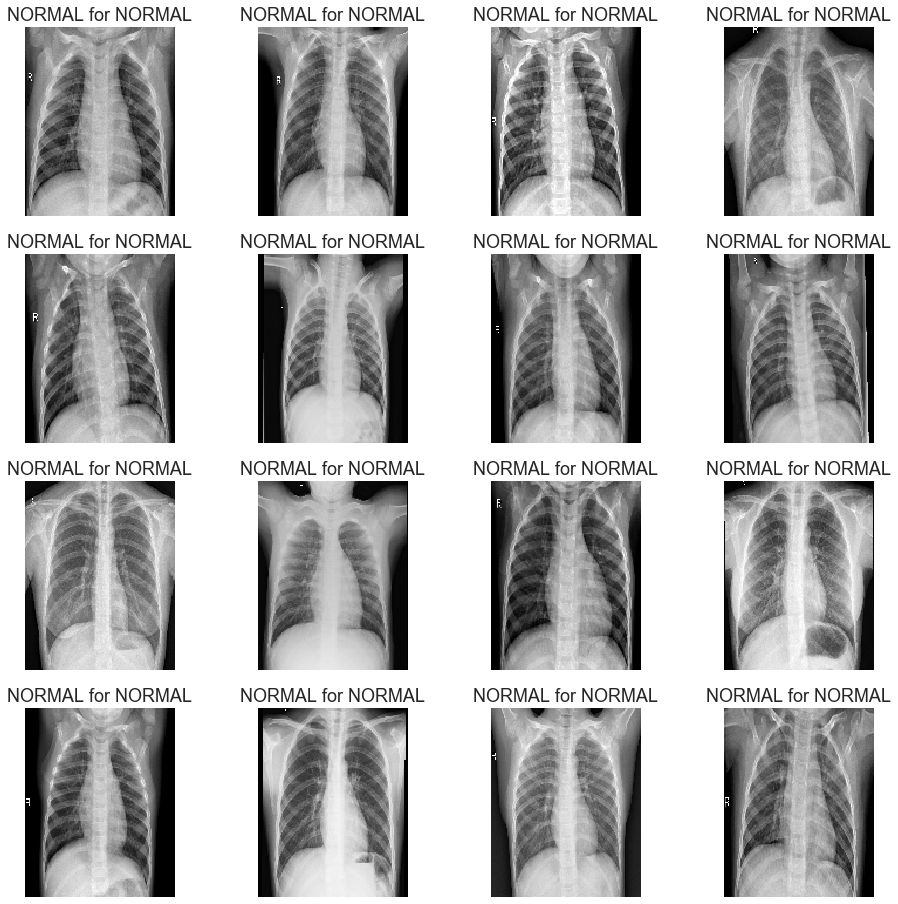

In [40]:
#Correct classification
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test[i])
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1

### AUGMENTED CNN INCORRECT CLASSIFICATIONS

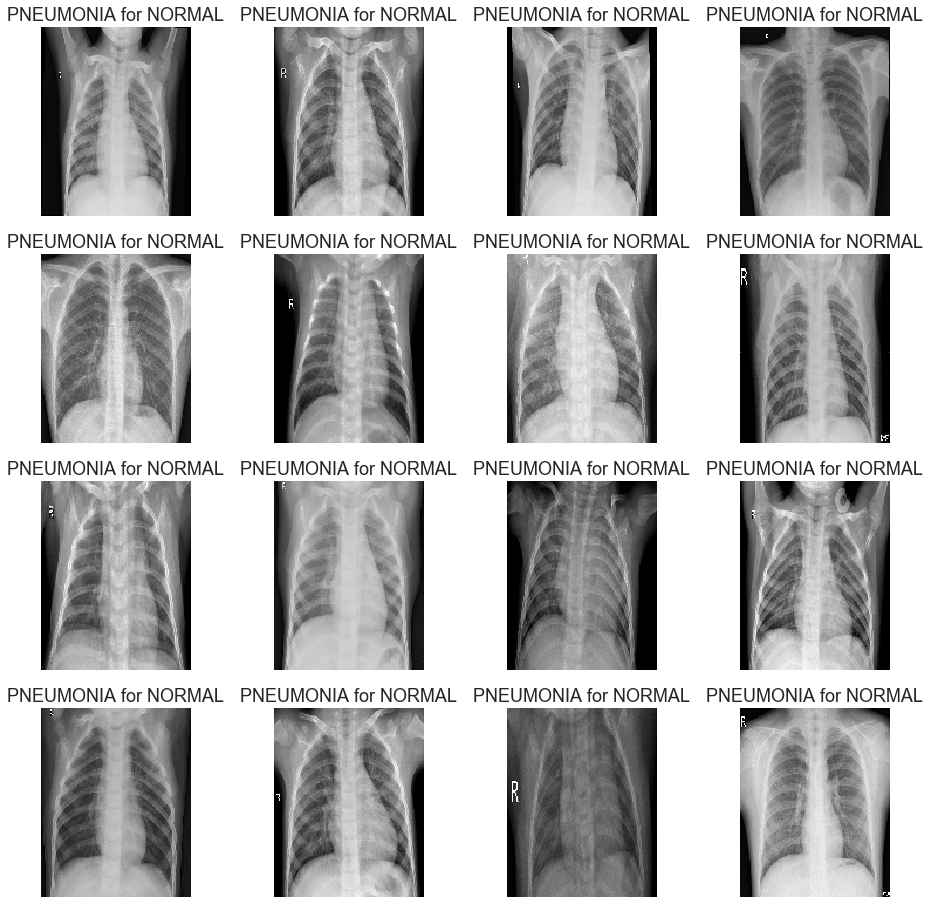

In [41]:
#Incorrect classification
pltsize=4
row_images = 4
col_images = 4

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
errors = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test[i])
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1

=======================================================================================================================

### 5 : Change your model so that it uses a pre-trained VGG16 model (trained on the ImageNet dataset) that is fine tuned to the pneumonia detection problem. 

Note: Consider unfreezing one of the convoluito0onal layers in the network as well as the dense layers.

In [42]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

In [43]:
pltsize=4
row_images = 3
col_images = 3
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(X_train[i_rand])
    plt.title((str(i_rand) + " " + y_train[i_rand]))

### VGG16 NETWORK

In [44]:
# build the VGG16 network
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = X_train[0].shape)
display(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0     

None

In [45]:
vgg16_last_layer = vgg16_model.output

# build a classifier model to put on top of the VGG16 model
x1 = Flatten()(vgg16_last_layer)
x2 = Dense(256, activation='relu')(x1)
x3 = Dropout(0.5)(x2)
final_layer = Dense(num_classes, activation = 'softmax')(x3)

# Assemble the full model out of both parts
full_model = keras.Model(vgg16_model.input, final_layer)

for layer in full_model.layers[:17]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.

full_model.compile(loss='categorical_crossentropy',
              optimizer=adam(lr=0.001),
              metrics=['accuracy'])
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0   

### TRAINING VGG16 MODEL WITH CHEST X-RAY IMAGES

In [46]:
batch_size = 128
epochs = 10

# Set up the callback to save the best model based on validaion data - notebook 2.2 needs to be run first.
best_weights_filepath = './vgg.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = full_model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
model.load_weights(best_weights_filepath,by_name=True)

#model.load_weights(r"D:\Semester2\AML\Assignment_2\vgg.hdf5", by_name=True)

Train on 668 samples, validate on 168 samples
Epoch 1/10
668/668 [==============================] - 74s 111ms/step - loss: 2.0112 - accuracy: 0.6467 - val_loss: 0.4365 - val_accuracy: 0.7143
Epoch 2/10
668/668 [==============================] - 75s 112ms/step - loss: 0.3031 - accuracy: 0.8713 - val_loss: 0.2364 - val_accuracy: 0.8810
Epoch 3/10
668/668 [==============================] - 74s 111ms/step - loss: 0.2022 - accuracy: 0.9087 - val_loss: 0.1422 - val_accuracy: 0.9345
Epoch 4/10
668/668 [==============================] - 72s 107ms/step - loss: 0.1510 - accuracy: 0.9506 - val_loss: 0.0932 - val_accuracy: 0.9583
Epoch 5/10
668/668 [==============================] - 73s 109ms/step - loss: 0.0959 - accuracy: 0.9701 - val_loss: 0.0819 - val_accuracy: 0.9524
Epoch 6/10
668/668 [==============================] - 75s 112ms/step - loss: 0.0749 - accuracy: 0.9716 - val_loss: 0.1044 - val_accuracy: 0.9702
Epoch 7/10
668/668 [==============================] - 70s 104ms/step - loss: 0.0568 

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### EVALUATION OF VGG16 ON TRAIN DATASET

In [48]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model.predict(X_train),axis=1)

train_acc_VGG = accuracy_score(y_train_num,pred)
# Print performance details
print(metrics.classification_report(y_train_num, pred))

print("Confusion matrix")

cm =metrics.confusion_matrix(y_train_num, pred)

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       230
           1       0.99      1.00      0.99       606

    accuracy                           0.99       836
   macro avg       0.99      0.98      0.99       836
weighted avg       0.99      0.99      0.99       836

Confusion matrix


### EVALUATION OF VGG16 ON TEST DATASET

In [49]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model.predict(X_test),axis=1)

test_acc_VGG = accuracy_score(y_test_num,pred)

# Print performance details
print(metrics.classification_report(y_test_num, pred))

print("Confusion matrix")
cm =metrics.confusion_matrix(y_test_num, pred)

fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.26      0.41        46
           1       0.70      1.00      0.82        78

    accuracy                           0.73       124
   macro avg       0.85      0.63      0.62       124
weighted avg       0.81      0.73      0.67       124

Confusion matrix


### CORRECT CLASSFICATIONS BY VGG16 MODEL

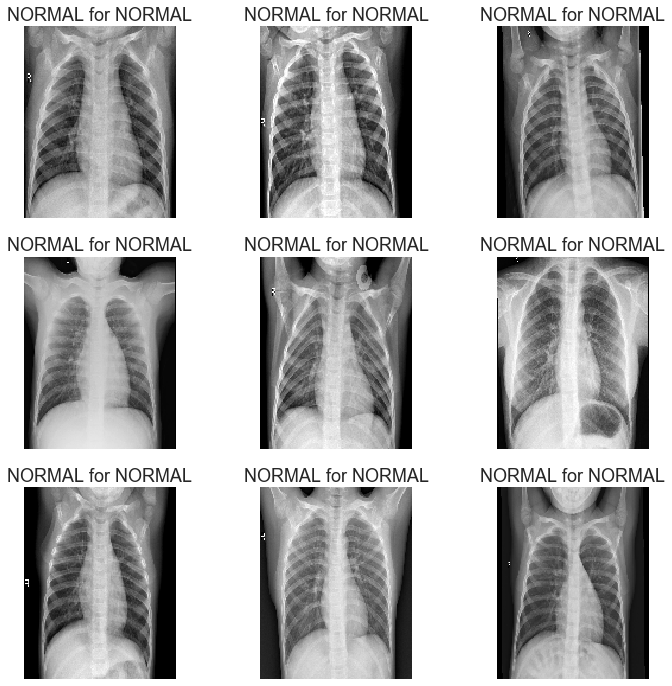

In [50]:
pltsize=4
row_images = 3
col_images = 3

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
corrects = predictions == y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test[i])
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1

### INCORRECT CLASSFICATIONS BY VGG16 MODEL

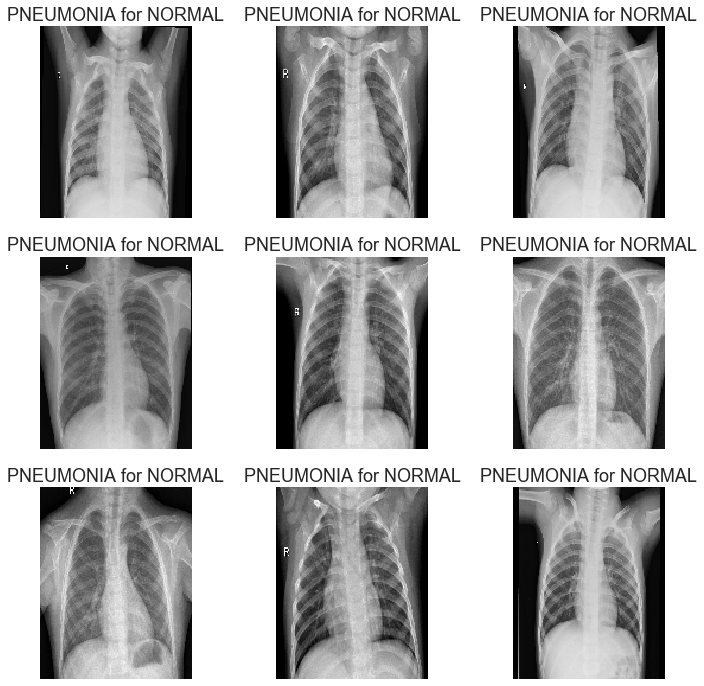

In [51]:
pltsize=4
row_images = 3
col_images = 3

maxtoshow = row_images * col_images
predictions = pred.reshape(-1)
errors = predictions != y_test_num
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(X_test[i])
        plt.title("{} for {}".format(classes_num_label[predictions[i]], y_test[i]))
        ii = ii + 1

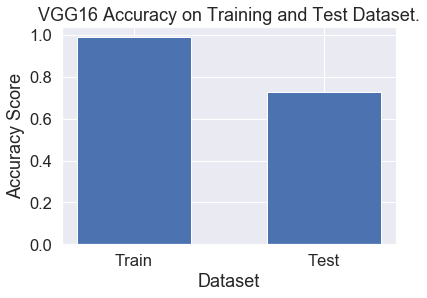

In [52]:
# Bar graph depicting the accuracy of Logistic Regression performing on Training and Test dataset .
plt.bar(['Train','Test'],[train_acc_VGG,test_acc_VGG], width = 0.6)
plt.title('VGG16 Accuracy on Training and Test Dataset.')
plt.xlabel('Dataset')
plt.ylabel('Accuracy Score')
plt.show()

In [70]:
index = ['LogReg', 'LeNet-5', 'LeNet-5 Aug', 'VGG16']
column = ['Training Accuracy', 'Testing Accuracy']
dframe = pd.DataFrame([[train_acc_LogReg, test_acc_LogReg],[train_acc_CNN, test_acc_CNN],[train_acc_Aug, test_acc_Aug],[train_acc_VGG, test_acc_VGG]] ,index= index, columns = column)
#dframe

In [71]:
fig= plt.figure(figsize=(10,8))
dframe.plot.bar(rot = 45)
plt.title('Accuracy of Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<Figure size 720x576 with 0 Axes>

### 6 : Compare the performance of the 4 models built in parts 2 to 5 using the supplied test set. A detailed reflection on the results of this comparison. Describing the most accurate model, why this model performed well, and the computational overhead of different techniques.

| Model | Accuracy on Train Data| Accuracy on Test Data
|------|------|------|
| Logestic Regression | 100 | 81.45 |
| LeNet5 CNN | 95.02 | 74.19 |
| LeNet5 CNN with Aug | 85.52 | 76.61 |
| VGG16 | 98.92 | 72.58 | 

__1. LogReg__:

* As a base model, we used Logistic Regression model to determine whether or not a given X-ray has pneumonia or not. It is relatively an easy model to implement as we treat each pixel as distinct feature.

* We have also converted the images to grayscale as color images have 3 channels which increases the model complexity (Number of features) and doesn't improve the predictive power. Also the images were reshaped to the desired size of (162, 128).

* The Logistic Regression classifier gives 100% accuracy on training data set while it could only give 81.45% on the testing dataset. Since the dataset is highly imbalanced and majority class is of pnueumonia we are getting higher accuracy. The model got overfitted.

__2. LeNet5 CNN:__

* LeNet-5 is one of the simplest architectures. It has 2 convolutional and 3 fully-connected layers.

* We selected 'adam' as the optimizer with learning rate of 0.0001. The sub-sampling layer used is average-pooling with trainable weights.

* __Unbalanced Dataset:__
    
    * Initially we trained the model on the unbalanced dataset. The model has an accuracy of 95.02% on training data set and 74.19% on testing dataset.
    * Even though the overall accuracy is lower than that of the Logistic Regression, it was capable of classifying the patients more accurately based on their chest X-ray images. True Negatives are also clearly visible through the confusion matrix to a certain extent.
    
* __Balanced Dataset:__
    
    * The class_weights are set to 'balanced' in order to sample the data. Here, the model accuracy decreases to 64% in case of test dataset. This was an unsual behaviour, because mostly after balancing the dataset we should intuitively get more accurates results due to low bias.
    
    * This model performed well in comparison to Logistic Regression model but not as good as LeNet 5 model which when trained on unbalanced dataset. However there was a significant difference of 10% in accuracy in terms of performance on test dataset.
    
__3. LeNet5 Augmentation:__

* This model performs best in terms of accuracy when tested on test dataset. The target classes are clearly distinguished, clearly visible from Confusion Matrix.

* In order to increase the size of the training dataset, number of Augmentation transformations are applied on the dataset.

* The ModelCheckpoints helped us to save the model by monitoring a specific parameter (val_loss, accuracy) of the model.

* Initially the model was converging to a certain value (74.29). But after introducing the learning rate and dense layer, the accuracy got boosted. The following transformations have been applied on the dataset.
    * Rotation: A rotation augmentation randomly rotates the image clockwise by a given number of degrees(15). 
    
    * Width shift: Moving pixel horizontally while keeping the image dimension same. 
    
    * Height shift: Moving pixel vertically while keeping the image dimension same. 
    
    * Zoom: A zoom augmentation randomly zooms the image in and either adds new pixel values around the image or interpolates pixel values respectively.
    
    * Fill mode: Points outside the boundaries of the input are filled according to the given mode. 
    
* We even tried with Brightness but it degraded the accuracy badly, as X-ray images are very sensitive to saturation level.

* The overall accuracy on the training dataset comes out to be 85.52% and 76.61% on testing data with Augmented data. 

* The most useful thing about ImageDatagenerator class is i,t doesn’t affect the data stored on the disk. It simply alters the data on the go while passing it to the model.

* Data augumentation enhances the training of CNN model. The model gets multiple variant of a single training data due to which it learns the main features. Networks trained with just data augmentation more easily adapt to different architectures and amount of training data, as opposed to weight decay and dropout, which require specific fine-tuning of their hyperparameters.

__4. VGG16:__

* The most unique aspect about VGG16 is that instead of making a huge number of hyper-parameters, it concentrated on providing 3x3 convolution layers with a stride 1 filter and only using the same padding and maxpool layer with a 2x2 stride 2 filter.

* Since we have less data available with us to train the model, we used VGG as a transfer learning platform. This allow us to just add the final fully connected layers and test the model on the testing data.

* Here, We achieved the accuracy of 72.58% on testing and 98.89% on training dataset. The model was capable of finding few of True Negatives as well.

* VGG has very high memory consumption and takes maximum time to train the model but since we are only using the last few layers of VGG16, It proves to be less computationally expensive.

### REFERENCES

[1] Cs229.stanford.edu. 2020. [online] Available at: <http://cs229.stanford.edu/proj2017/final-reports/5231221.pdf> [Accessed 1 May 2020].
        
[2] Ieeexplore.ieee.org. 2020. Pneumonia Detection Using CNN Based Feature Extraction - IEEE Conference Publication. [online] Available at: <https://ieeexplore.ieee.org/document/8869364> [Accessed 1 May 2020].